In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "../data_segments/data_balanced_duplicate_sample/"
sz=256

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
os.listdir(PATH)

['train', 'valid', 'models']

In [7]:
files = os.listdir(f'{PATH}valid/Celiac')[:5]
files

['C13-67_03_3500_6000_2.jpg',
 'C10-51_01_2997_8325_2.jpg',
 'C04-17_05_4662_5661_0.jpg',
 'C10-51_02_3500_1500_3.jpg',
 'C10-51_02_7000_7000_1.jpg']

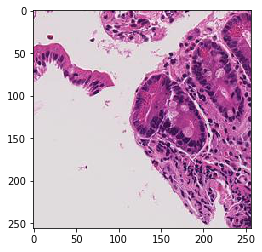

In [8]:
img = plt.imread(f'{PATH}valid/Celiac/{files[0]}')
plt.imshow(img);

In [10]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 2475/2475 [32:02<00:00,  1.53it/s]


In [11]:
learn.fit(0.001, 2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.413578   0.361522   0.819439  
    1      0.384056   0.355896   0.818959                      



[0.3558956651595301, 0.8189589857621583]

## Visualising Results

In [12]:
# This is the label for a val data
data.val_y

array([0, 0, 0, ..., 2, 2, 2])

In [13]:
# from here we know that 'Celiac' is label 0 and 'EE' is label 1 and 'Normal' is label 2
data.classes

['Celiac', 'EE', 'Normal']

In [14]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(158384, 3)

Most Correct Celiac


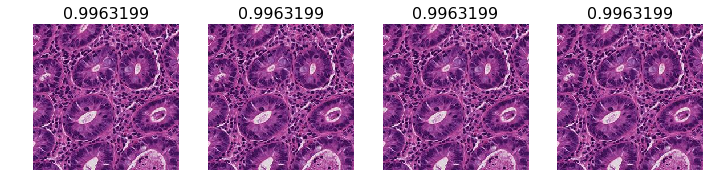

In [15]:
imr = ImageModelResults(data.val_ds, log_preds)
print('Most Correct Celiac')
imr.plot_most_correct(0)

Most Correct EE


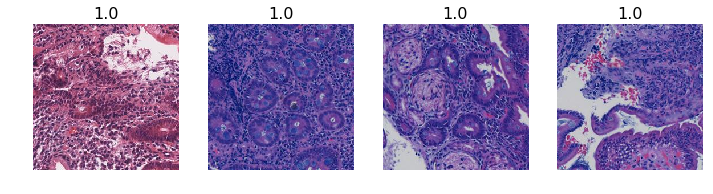

In [16]:
print('Most Correct EE')
imr.plot_most_correct(1)

Most Correct Normal


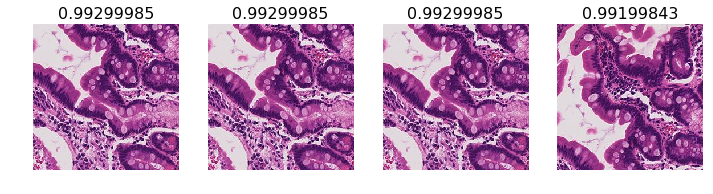

In [17]:
print('Most Correct Normal')
imr.plot_most_correct(2)

Most Incorrect Celiac


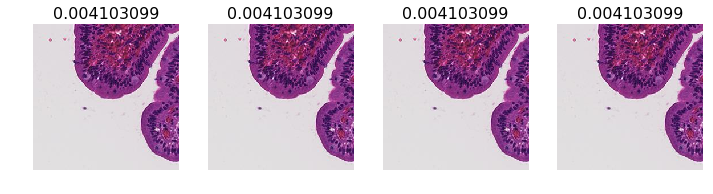

In [18]:
print('Most Incorrect Celiac')
imr.plot_most_incorrect(0)

Most Incorrect EE


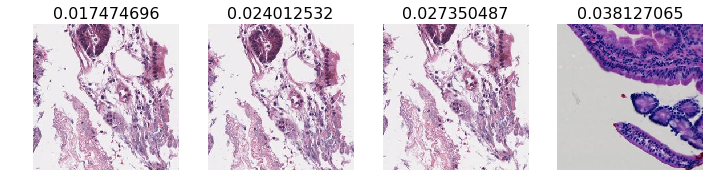

In [19]:
print('Most Incorrect EE')
imr.plot_most_incorrect(1)

Most Incorrect Normal


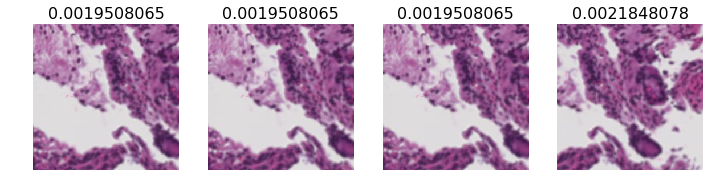

In [20]:
print('Most Incorrect Normal')
imr.plot_most_incorrect(2)

In [21]:
preds = np.argmax(log_preds, axis=1)

In [22]:
y = data.val_y

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[40796   108 18032]
 [   40 51669    75]
 [10194   225 37245]]


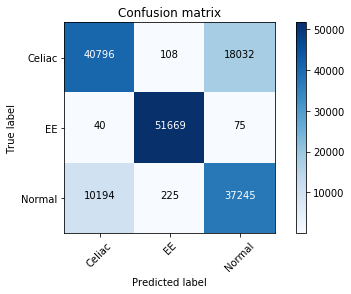

In [24]:
plot_confusion_matrix(cm, data.classes)

## Finding a optimum learning rate

In [25]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [26]:
lrf=learn.lr_find()

 79%|███████▊  | 5793/7372 [01:34<00:25, 60.99it/s, loss=1.51] 

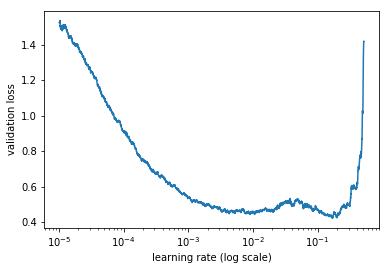

In [27]:
learn.sched.plot()

## Data Augmentation

In [28]:
# Using predefined augmentations transforms_top_down
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

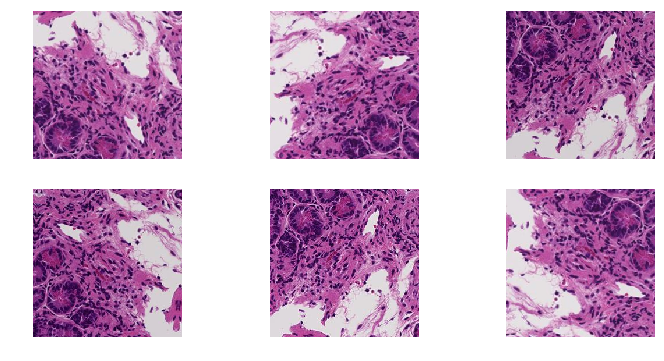

In [29]:
# Visualising the augmentation
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [30]:
# Initializing the data with augmentation and learn method
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.precompute = False

In [31]:
learn.fit(1e-3, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                      
    0      0.451073   0.400342   0.80553   
    1      0.429146   0.374073   0.815846                      
    2      0.407551   0.367646   0.820506                      


[0.36764647649151955, 0.8205058591776947]

In [32]:
learn.save('256_resnet34_duplicates_lastlayer')

In [33]:
learn.load('256_resnet34_duplicates_lastlayer')

## Unfreezing layers and using Differential learning rates

In [34]:
# Unfreeze all layers for training
learn.unfreeze()

In [35]:
lrf=learn.lr_find()

 81%|████████  | 5951/7372 [38:42<08:53,  2.66it/s, loss=0.809]  

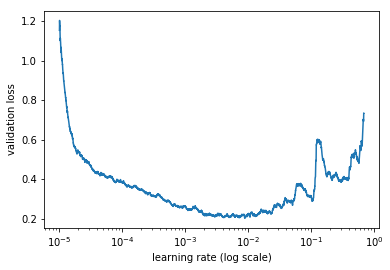

In [36]:
learn.sched.plot()

In [37]:
lr = (1e-4 + 1e-3)/2

In [38]:
lr=np.array([lr/9,lr/3,lr])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                        
    0      0.247766   0.217035   0.900362  
    1      0.187184   0.191431   0.913482                        
    2      0.156728   0.186838   0.915762                        
    3      0.135958   0.178328   0.92462                         
Validation:  98%|█████████▊| 2416/2475 [07:22<00:09,  6.19it/s]  

In [ ]:
learn.save('256_resnet34_duplicates_all')
learn.load('256_resnet34_duplicates_all')

## Analyzing results

### Confusion Matrix and Accuracy with Test Time Augmentation

In [ ]:
# Getting log predictions with TTA
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

In [ ]:
log_preds.shape

In [ ]:
log_preds_mean = np.mean(log_preds, 0)

In [ ]:
np.save('data_segments/logpreds_resnet34_all_layers256x256_duplicates_TTA.npy', log_preds)

In [ ]:
preds = np.argmax(probs, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

### Visualizing results with TTA

In [ ]:
imr = ImageModelResults(data.val_ds, log_preds_mean)
print('Most Correct Celiac')
imr.plot_most_correct(0)

In [ ]:
print('Most Correct EE')
imr.plot_most_correct(1)

In [ ]:
print('Most Correct Noraml')
imr.plot_most_correct(2)

In [ ]:
print('Most Incorrect Celiac')
imr.plot_most_incorrect(0)

In [ ]:
print('Most Incorrect EE')
imr.plot_most_incorrect(1)

In [ ]:
print('Most Incorrect Normal')
imr.plot_most_incorrect(2)

In [ ]:
print('Most Uncertain Celiac')
imr.plot_most_uncertain(0)

In [ ]:
print('Most Uncertain EE')
imr.plot_most_uncertain(1)

In [ ]:
print('Most Uncertain Normal')
imr.plot_most_uncertain(2)

### Confusion Matrix and Accuracy without Test Time Augmentation

In [ ]:
# Getting log predictions without TTA
log_preds = learn.predict()

In [ ]:
preds = np.argmax(log_preds, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)